# Creating a keras sequential model to interpret any single digit number or a letter

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

## Importing the Data

In [2]:
"""
Creates the mapping dictionary to map from the number 
to the corresponding letter/digit. 

Note: there are not 62 unique labels because some letters 
like c, i, j, k, l, m, o, p, s, u, v, w, x, y, z have 
very similar lowercase and uppercase letters. 
Hence there are 46 labels
"""

mapping_file = open("EMNIST/emnist-bymerge-mapping.txt")

mapping = {}
for line in mapping_file:
    line = line.split(" ")
    mapping[line[0]] = chr(int(line[1]))

In [3]:
"""
Extracting the information frome mnist-digits-train.csv file, 
emnist-digits-test.csv and storing the contents in Xtrain, 
Ttrain (Used to train the model), and Xtest, 
Ttest (Used to test the model).

Xtrain, Xtest contains rows of an array with 784. Which represents 
an 28 by 28 pixel image and the values represent the greyscale / 255.
Xtrain contains 697 931 rows while Xtest contains 116 322 rows.

Ttrain, Ttest contains a number from 0 to 9 which corresponds 
to the handwritten digit for their repesctive row of numbers.
"""

Xtrain = pd.read_csv("EMNIST/emnist-bymerge-train.csv", dtype="int16")
Xtest = pd.read_csv("EMNIST/emnist-bymerge-test.csv", dtype="int16")

Ttrain = Xtrain["24"]
Ttest = Xtest["24"]

Xtrain.drop(columns=["24"], inplace=True)
Xtest.drop(columns=["24"], inplace=True)

## Creating, Compiling, Training and Testing the Model

In [4]:
"""
Uses keras to create a keras sequential model with 4 layers. 
First layer takes the input which corresponds to our data. 
The second, and third layer is the hidden layer. The dense represents that 
this layer is fully connected to the previous layer. It also uses 
the rectify linear unit activation function. The fourth layer 
represents all the possible outputs which corresponds to 
the possible digits and letters in our data set. It also uses the 
softmax activation function.
"""

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(784,1)), 
    keras.layers.Dense(392, activation="relu"),
    keras.layers.Dense(112, activation="relu"),
    keras.layers.Dense(47, activation="softmax")
])

In [5]:
"""
Compiles the model with adam (Adaptive Moment Estimation) 
optimizer, cross entropy loss function, and we want to 
focus on accuracy.
"""

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
"""
Trains the model with the given Xtrain and Ttrain
with the batch size of 1000 and epochs of 12.
"""

model.fit(Xtrain, Ttrain, batch_size=1000, epochs=12, shuffle=True)

Epoch 1/12
698/698 [==============================] - 18s 23ms/step - loss: 3.2292 - accuracy: 0.3819
Epoch 2/12
698/698 [==============================] - 17s 25ms/step - loss: 0.9543 - accuracy: 0.7130
Epoch 3/12
698/698 [==============================] - 18s 25ms/step - loss: 0.6317 - accuracy: 0.8031
Epoch 4/12
698/698 [==============================] - 20s 29ms/step - loss: 0.5289 - accuracy: 0.83000s - l
Epoch 5/12
698/698 [==============================] - 22s 31ms/step - loss: 0.4809 - accuracy: 0.8429
Epoch 6/12
698/698 [==============================] - 23s 32ms/step - loss: 0.4507 - accuracy: 0.85091s - loss: 0.4508 - accura - ETA: 0s - loss: 0
Epoch 7/12
698/698 [==============================] - 20s 29ms/step - loss: 0.4292 - accuracy: 0.8564
Epoch 8/12
698/698 [==============================] - 18s 26ms/step - loss: 0.4143 - accuracy: 0.8604
Epoch 9/12
698/698 [==============================] - 18s 26ms/step - loss: 0.4000 - accuracy: 0.8647
Epoch 10/12
698/698 [=========

In [7]:
test_loss, test_acc = model.evaluate(Xtest, Ttest, verbose=1) 

print('Test accuracy:', test_acc)

3636/3636 [==============================] - 8s 2ms/step - loss: 0.4232 - accuracy: 0.8590
Test accuracy: 0.859046459197998


## User Input with Test Data
### The user can input any number from 0 to 39 998 (Inclusive) and the function will output the image of the number, the correct number that is being represented, and the model's predicted results

In [8]:
def test_data(image_num):
    """
    Takes an input from 0, 116 321 and uses the validation data 
    from the data set and will print the image, actual number 
    and the predicted number by the model.
    """
    image = np.array(Xtest.loc[image_num])
    
    # Predicts the model 
    prediction = model.predict(image.reshape(1, 784))

    image = image.reshape((28, 28))

    plt.imshow(image.T)
    plt.show()

    print("Actual Result: " + mapping[str(Ttest.loc[image_num])])

    predicted_num = np.argmax(prediction[0])
    print("Model Predicted Number: " + mapping[str(predicted_num)])

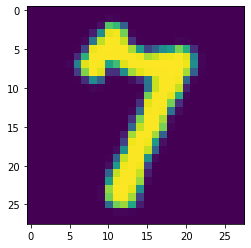

Actual Result: 7
Model Predicted Number: 7


In [9]:
test_data(116321)
# Input any value between 0 and 116 321 inclusive

## User Input with a Created Image
### The user can alter the number.png and the model will attempt to accurately decipher the written number.

In [10]:
def read_written_num(filename):
    img = Image.open(filename)
    img = img.resize((28, 28))
    # Converts the image to a greyscall image
    img = np.asarray(img)
    if len(img.shape) == 3:
        img = np.dot(img[:28, :28, :3], [0.2989, 0.5870, 0.1140])
    
    # Displays the image
    plt.imshow(img)
    plt.show()
    
    # Reshapes the image to the correct shape to use in the model
    img = img.T
    img = img.reshape((1, 784))
    
    predictions = model.predict([img])
    predicted_num = np.argmax(predictions[0])
    print("Model Predicted Number: " + mapping[str(predicted_num)])

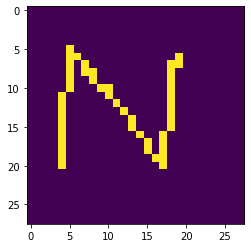

Model Predicted Number: N


In [11]:
read_written_num("picture.png")
# Attempts to read the number written in number.png file

## Saving the Created Model

In [12]:
"""
Save a Model (1st way)

This method will save
    Architecture of the model, allowing to recreate the model
    The weights of the model
    Training configuartions (loss, optimizer)
    State of the optimizer, allowing to resume training exactly where you left off.
"""
model.save("Model.h5")

"""
Loads a saved model
"""
model = keras.models.load_model("Model.h5")

In [13]:
"""
Save a Model's Architecture
"""
json_string = model.to_json()
# yaml_string = model.to_yaml()
"""
Loads the Model's Architecture
"""
model_architecture = keras.models.model_from_json(json_string)
# model_architecture = keras.models.model_from_yaml(yaml_string)

In [14]:
"""
Save a Model's Weights
"""
model.save_weights("Model_Weights.h5")
"""
Loads the Model's Weights
"""
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(784,1)), 
    keras.layers.Dense(392, activation="relu"),
    keras.layers.Dense(112, activation="relu"),
    keras.layers.Dense(47, activation="softmax")
])
model2.load_weights("Model_Weights.h5")